In [1]:
# ===============================
# MASTER PIPELINE – KLASZTER LSTM
# ===============================

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Mixed precision és GPU memória kezelés
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# --- Segédfüggvények ---

def topk_acc_numpy(y_true, y_proba, k=5):
    if y_proba.ndim != 2:
        raise ValueError("y_proba 2D mátrix legyen (n_samples, n_classes).")

    n_classes = y_proba.shape[1]
    if n_classes == 0:
        return 0.0
    
    k_eff = min(k, n_classes)
    topk_idx = np.argpartition(y_proba, -k_eff, axis=1)[:, -k_eff:]
    correct = (topk_idx == y_true[:, None]).any(axis=1)
    return float(correct.mean())

def train_test_split_seq(X_list, y, split_ratio=0.8):
    n = len(y) 
    split = int(n * split_ratio)  
    
    X_train = [X[:split] for X in X_list]
    X_test  = [X[split:] for X in X_list]

    y_train, y_test = y[:split], y[split:]

    return X_train, X_test, y_train, y_test

def preprocess_dataframe(df, coarsen_factor=2):
    df = df.copy()

    df["hour"] = df["t"].astype(int)

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 48)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 48)
    df["is_weekend"] = (df["date"].dt.dayofweek >= 5).astype(int)

    num_cols = ["temperature", "rain", "daily_radius_of_gyration",
                "radius_of_gyration", "unique_cells_count"]

    for c in num_cols:
        if c not in df.columns:
            df[c] = 0.0

    df[num_cols] = df[num_cols].astype(float)

    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return df
# --- Szekvenciák felépítése -> 10 hogy gyorsítsam ---

def build_sequences_for_user(user_df, seq_len=20):
    df = user_df.copy().reset_index(drop=True)


    df["target"] = df["cell_id"].shift(-1)
    df = df.dropna(subset=["target"]).reset_index(drop=True) 

    y_all, uniques = pd.factorize(df["target"].astype(int))
    df["target_enc"] = y_all.astype(np.int32)
    num_classes = len(uniques) 

    cell_all, cell_uniques = pd.factorize(df["cell_id"].astype(int))
    df["cell_enc"] = cell_all.astype(np.int32)
    cell_vocab_size = int(df["cell_enc"].max()) + 2 

    df["dayofweek_enc"], _ = pd.factorize(df["days_of_week"])

    hour_ids = df["hour"].astype(np.int32).values
    num_cols = [
        "temperature", "rain", "daily_radius_of_gyration",
        "radius_of_gyration", "unique_cells_count", "fraction_missing",
        "hour_sin", "hour_cos", "is_weekend",
        "is_home", "is_workplace",
        "dayofweek_enc"
    ]
    num_feats = df[num_cols].astype(np.float32).values

    X_cell, X_hour, X_num, y = [], [], [], []
    for i in range(len(df) - seq_len):
        sl = slice(i, i + seq_len)
        X_cell.append(df["cell_enc"].values[sl])
        X_hour.append(hour_ids[sl])
        X_num.append(num_feats[sl, :])
        y.append(df["target_enc"].values[i + seq_len - 1])

    if len(y) == 0:
        return None

    return (np.asarray(X_cell, dtype=np.int32),
            np.asarray(X_hour, dtype=np.int32),
            np.asarray(X_num,  dtype=np.float32),
            np.asarray(y,      dtype=np.int32),
            cell_vocab_size, 48, num_classes)  

# --- Modellépítés ---

def build_lstm_multi(num_cells, num_hours, num_numeric, num_classes):
    inp_cell = layers.Input(shape=(None,), dtype="int32", name="cell_in")

    emb_cell = layers.Embedding(num_cells, 64, mask_zero=False)(inp_cell)
    x_cell = layers.LSTM(128, recurrent_dropout=0.1)(emb_cell)  

    inp_hour = layers.Input(shape=(None,), dtype="int32", name="hour_in")
    emb_hour = layers.Embedding(num_hours, 16, mask_zero=False)(inp_hour)
    x_hour = layers.LSTM(32)(emb_hour)  

    inp_num = layers.Input(shape=(None, num_numeric), dtype="float32", name="num_in")
    x_num = layers.LSTM(32)(inp_num)

    x = layers.Concatenate()([x_cell, x_hour, x_num])

    x = layers.Dense(128, activation="relu")(x)

    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=[inp_cell, inp_hour, inp_num], outputs=out)

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# --- Klaszter szekvenciák építése ---
def build_sequences_for_cluster(cluster_df, seq_len=20):
    all_X_cell, all_X_hour, all_X_num, all_y = [], [], [], []
    cell_vocab_size, num_classes = 0, 0

    # a klaszter minden felhasználójára szekvenciákat épít
    for uid, dfu in cluster_df.groupby("uid"):
        seqs = build_sequences_for_user(dfu, seq_len=seq_len)
        if seqs is None: continue
        X_cell, X_hour, X_num, y, cell_vocab, hour_vocab, n_classes = seqs
        all_X_cell.append(X_cell)
        all_X_hour.append(X_hour)
        all_X_num.append(X_num)
        all_y.append(y)
        cell_vocab_size = max(cell_vocab_size, cell_vocab)
        num_classes = max(num_classes, n_classes)

    # Ha nincs adat a klaszterben, None-t ad vissza, ha van, akkor összefűzi az összes felhasználó szekvenciáját
    if len(all_y) == 0:
        return None
    return (np.vstack(all_X_cell),
            np.vstack(all_X_hour),
            np.vstack(all_X_num),
            np.concatenate(all_y),
            cell_vocab_size, hour_vocab, num_classes)

# --- Klaszter modell futtatása ---
def run_cluster_model_lstm_multi(df_cluster, seq_len=20, epochs=20, cluster_id=None):
    # adott klaszter szekvenciáinak felépítése
    seqs = build_sequences_for_cluster(df_cluster, seq_len=seq_len)
    if seqs is None: return None
    X_cell, X_hour, X_num, y, cell_vocab, hour_vocab, num_classes = seqs

    # adatok felosztása tanító és teszt részre
    X_train, X_test, y_train, y_test = train_test_split_seq([X_cell, X_hour, X_num], y, split_ratio=0.8)

    # modell felépítése 
    model = build_lstm_multi(cell_vocab, hour_vocab, X_num.shape[2], num_classes)
    # korai leállítás beállítása
    early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    # modell tanítása
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=512,
        verbose=1,
        callbacks=[early_stop]
    )

    # --- Tanulási görbék megjelenítése ---
    plt.figure(figsize=(8, 5))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Klaszter {cluster_id} - Loss görbe")
    plt.show()

    # --- Kiértékelés a teszt halmazon ---
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"[Klaszter {cluster_id}] Test accuracy: {test_acc:.3f}, Test loss: {test_loss:.3f}")

    # --- Predikciók és top-k pontosság ---
    proba_test = model.predict(X_test, verbose=0)
    pred_test = np.argmax(proba_test, axis=1)
    acc = accuracy_score(y_test, pred_test)
    top5 = topk_acc_numpy(y_test, proba_test, k=5)

    # --- Eredmények összefoglalása ---
    return {
        "cluster_id": cluster_id,
        "model_type": "LSTM-multi",
        "num_classes": num_classes,
        "train_accuracy": history.history.get("accuracy", [None])[-1],
        "val_accuracy": history.history.get("val_accuracy", [None])[-1],
        "test_accuracy": test_acc,
        "accuracy": acc,
        "top5_accuracy": top5,
        "epochs_ran": len(history.history["loss"]),
        "final_train_loss": history.history["loss"][-1],
        "final_val_loss": history.history["val_loss"][-1],
        "best_val_loss": min(history.history["val_loss"]),
        "best_epoch": np.argmin(history.history["val_loss"]) + 1,
        "num_samples": len(df_cluster)
    }


In [3]:
# Klaszterek létrehozása
def load_and_cluster(csv_file="df_test_10k.csv", n_clusters=4):
    df = pd.read_csv(csv_file, parse_dates=["date"])
    df_processed = preprocess_dataframe(df)
    
    # Globális skálázás a numerikus oszlopokra
    num_cols = ["temperature", "rain", "daily_radius_of_gyration",
                "radius_of_gyration", "unique_cells_count"]

    scaler = StandardScaler()
    df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

    user_features = df_processed.groupby("uid").agg(
        mean_rg=("radius_of_gyration", "mean"),
        std_rg=("radius_of_gyration", "std"),
        mean_daily_rg=("daily_radius_of_gyration", "mean"),
        uniq_cells=("unique_cells_count", "mean"),
        frac_home=("is_home", "mean"),
        frac_work=("is_workplace", "mean"),
        weekend_ratio=("is_weekend", "mean"),
        # mean_hour_sin=("hour_sin", "mean"),
        # mean_hour_cos=("hour_cos", "mean"),
        # mean_temp=("temperature", "mean"),
        # std_temp=("temperature", "std"),
        # mean_rain=("rain", "mean")
    ).fillna(0)

    #skálázás user_features adatokra
    scaler_user = StandardScaler()
    X_scaled = scaler_user.fit_transform(user_features)

    # 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    user_features["cluster"] = kmeans.fit_predict(X_scaled)

    df_proc_wclu = df_processed.merge(user_features[["cluster"]], on="uid", how="left")
    
    #  Mentés a felhasználói klasztercímkékkel
    user_clusters = user_features[["cluster"]].reset_index()
    user_clusters.to_csv("user_clusters.csv", index=False)
    print("✅ Klasztercímkék elmentve: user_clusters.csv")

    return df_proc_wclu

✅ Klasztercímkék elmentve: user_clusters.csv

=== Klaszter 0 ===
Epoch 1/20
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 555s 154ms/step - accuracy: 0.3390 - loss: 2.6515 - val_accuracy: 0.3473 - val_loss: 2.5129
Epoch 2/20
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 561s 157ms/step - accuracy: 0.3714 - loss: 2.3925 - val_accuracy: 0.3487 - val_loss: 2.4683
Epoch 3/20
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 561s 157ms/step - accuracy: 0.3871 - loss: 2.3211 - val_accuracy: 0.3544 - val_loss: 2.4645
Epoch 4/20
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 577s 162ms/step - accuracy: 0.3964 - loss: 2.2798 - val_accuracy: 0.3588 - val_loss: 2.4619
Epoch 5/20
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 570s 160ms/step - accuracy: 0.4034 - loss: 2.2505 - val_accuracy: 0.3589 - val_loss: 2.4633
Epoch 6/20
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 557s 156ms/step - accuracy: 0.4092 - loss: 2.2275 - val_accuracy: 0.3595 - val_loss: 2.4687
Epoch 7/20
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 581s 162ms/step - accuracy: 0.4141 - loss: 2.2094 - val_accuracy: 0.3583 - val_loss: 2.46

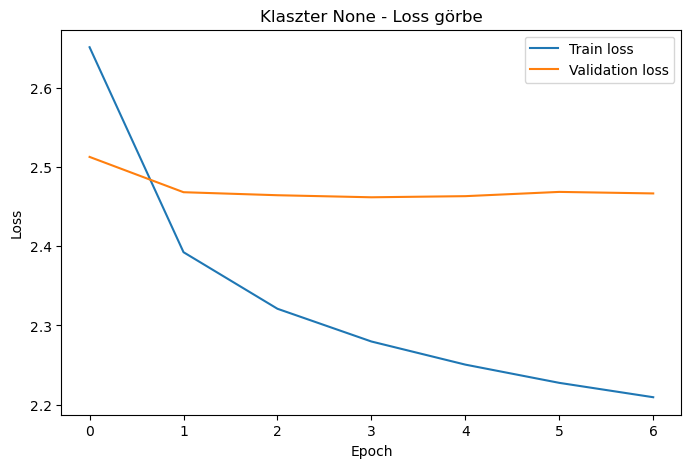

[Klaszter None] Test accuracy: 0.345, Test loss: 2.521
Eredmény elmentve: results_cluster0.csv


In [ ]:
# 0-s klaszter


CLUSTER_ID = 0

# Adatok betöltése + klaszterezés

df_proc_wclu = load_and_cluster("../lstm_egyeni/df_test_10k.csv")

# Kiválasztott klaszter
df_clu = df_proc_wclu[df_proc_wclu["cluster"] == CLUSTER_ID]

print(f"\n=== Klaszter {CLUSTER_ID} ===")
res = run_cluster_model_lstm_multi(df_clu, seq_len=20, epochs=20)

if res:
    res["cluster"] = CLUSTER_ID
    out_file = f"results_cluster{CLUSTER_ID}.csv"
    pd.DataFrame([res]).to_csv(out_file, index=False)
    print(f"Eredmény elmentve: {out_file}")



=== Klaszter 1 ===
Epoch 1/20
5613/5613 ━━━━━━━━━━━━━━━━━━━━ 1112s 197ms/step - accuracy: 0.1922 - loss: 3.5703 - val_accuracy: 0.2162 - val_loss: 3.3723
Epoch 2/20
5613/5613 ━━━━━━━━━━━━━━━━━━━━ 1035s 184ms/step - accuracy: 0.2329 - loss: 3.2802 - val_accuracy: 0.2246 - val_loss: 3.3053
Epoch 3/20
5613/5613 ━━━━━━━━━━━━━━━━━━━━ 1070s 191ms/step - accuracy: 0.2463 - loss: 3.2162 - val_accuracy: 0.2376 - val_loss: 3.2789
Epoch 4/20
5613/5613 ━━━━━━━━━━━━━━━━━━━━ 1070s 191ms/step - accuracy: 0.2530 - loss: 3.1810 - val_accuracy: 0.2341 - val_loss: 3.2677
Epoch 5/20
5613/5613 ━━━━━━━━━━━━━━━━━━━━ 1095s 195ms/step - accuracy: 0.2579 - loss: 3.1576 - val_accuracy: 0.2372 - val_loss: 3.2588
Epoch 6/20
5613/5613 ━━━━━━━━━━━━━━━━━━━━ 1112s 197ms/step - accuracy: 0.2606 - loss: 3.1409 - val_accuracy: 0.2362 - val_loss: 3.2542
Epoch 7/20
5613/5613 ━━━━━━━━━━━━━━━━━━━━ 1149s 205ms/step - accuracy: 0.2630 - loss: 3.1278 - val_accuracy: 0.2414 - val_loss: 3.2495
Epoch 8/20
5613/5613 ━━━━━━━━━━━━━━

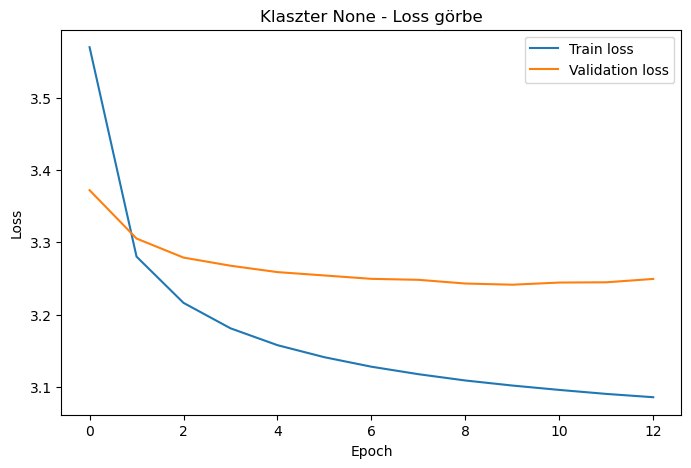

[Klaszter None] Test accuracy: 0.246, Test loss: 3.227
Eredmény elmentve: results_cluster1.csv


In [ ]:
# 1-es klaszter


CLUSTER_ID = 1

# Adatok betöltése + klaszterezés

df_proc_wclu = load_and_cluster("../lstm_egyeni/df_test_10k.csv")

# Kiválasztott klaszter
df_clu = df_proc_wclu[df_proc_wclu["cluster"] == CLUSTER_ID]

print(f"\n=== Klaszter {CLUSTER_ID} ===")
res = run_cluster_model_lstm_multi(df_clu, seq_len=20, epochs=20)

if res:
    res["cluster"] = CLUSTER_ID
    out_file = f"results_cluster{CLUSTER_ID}.csv"
    pd.DataFrame([res]).to_csv(out_file, index=False)
    print(f"Eredmény elmentve: {out_file}")

✅ Klasztercímkék elmentve: user_clusters.csv

=== Klaszter 2 ===
Epoch 1/20
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 559s 159ms/step - accuracy: 0.1502 - loss: 4.3986 - val_accuracy: 0.2109 - val_loss: 3.9846
Epoch 2/20
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 537s 154ms/step - accuracy: 0.2310 - loss: 3.8559 - val_accuracy: 0.2393 - val_loss: 3.8602
Epoch 3/20
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 550s 157ms/step - accuracy: 0.2504 - loss: 3.7534 - val_accuracy: 0.2469 - val_loss: 3.8089
Epoch 4/20
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 551s 158ms/step - accuracy: 0.2615 - loss: 3.6984 - val_accuracy: 0.2537 - val_loss: 3.7846
Epoch 5/20
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 579s 166ms/step - accuracy: 0.2676 - loss: 3.6625 - val_accuracy: 0.2581 - val_loss: 3.7676
Epoch 6/20
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 624s 178ms/step - accuracy: 0.2721 - loss: 3.6360 - val_accuracy: 0.2597 - val_loss: 3.7578
Epoch 7/20
3496/3496 ━━━━━━━━━━━━━━━━━━━━ 619s 177ms/step - accuracy: 0.2754 - loss: 3.6153 - val_accuracy: 0.2604 - val_loss: 3.75

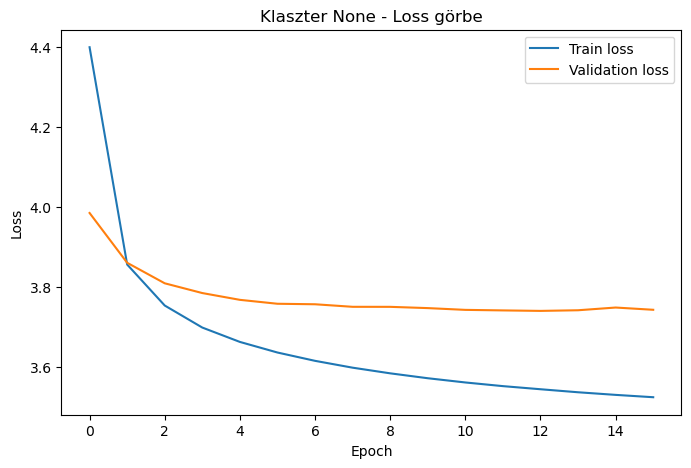

[Klaszter None] Test accuracy: 0.249, Test loss: 3.795
Eredmény elmentve: results_cluster2.csv


In [ ]:
# 2-es klaszter


CLUSTER_ID = 2

# Adatok betöltése + klaszterezés

df_proc_wclu = load_and_cluster("../lstm_egyeni/df_test_10k.csv")

# Kiválasztott klaszter
df_clu = df_proc_wclu[df_proc_wclu["cluster"] == CLUSTER_ID]

print(f"\n=== Klaszter {CLUSTER_ID} ===")
res = run_cluster_model_lstm_multi(df_clu, seq_len=20, epochs=20)

if res:
    res["cluster"] = CLUSTER_ID
    out_file = f"results_cluster{CLUSTER_ID}.csv"
    pd.DataFrame([res]).to_csv(out_file, index=False)
    print(f"Eredmény elmentve: {out_file}")

✅ Klasztercímkék elmentve: user_clusters.csv

=== Klaszter 3 ===
Epoch 1/20
3765/3765 ━━━━━━━━━━━━━━━━━━━━ 638s 168ms/step - accuracy: 0.1545 - loss: 3.9182 - val_accuracy: 0.1796 - val_loss: 3.6607
Epoch 2/20
3765/3765 ━━━━━━━━━━━━━━━━━━━━ 617s 164ms/step - accuracy: 0.2020 - loss: 3.5489 - val_accuracy: 0.1956 - val_loss: 3.5576
Epoch 3/20
3765/3765 ━━━━━━━━━━━━━━━━━━━━ 654s 172ms/step - accuracy: 0.2181 - loss: 3.4656 - val_accuracy: 0.2011 - val_loss: 3.5284
Epoch 4/20
3765/3765 ━━━━━━━━━━━━━━━━━━━━ 648s 172ms/step - accuracy: 0.2271 - loss: 3.4216 - val_accuracy: 0.2093 - val_loss: 3.5039
Epoch 5/20
3765/3765 ━━━━━━━━━━━━━━━━━━━━ 653s 173ms/step - accuracy: 0.2327 - loss: 3.3932 - val_accuracy: 0.2090 - val_loss: 3.4965
Epoch 6/20
3765/3765 ━━━━━━━━━━━━━━━━━━━━ 660s 175ms/step - accuracy: 0.2369 - loss: 3.3722 - val_accuracy: 0.2148 - val_loss: 3.4852
Epoch 7/20
3765/3765 ━━━━━━━━━━━━━━━━━━━━ 706s 188ms/step - accuracy: 0.2403 - loss: 3.3561 - val_accuracy: 0.2132 - val_loss: 3.48

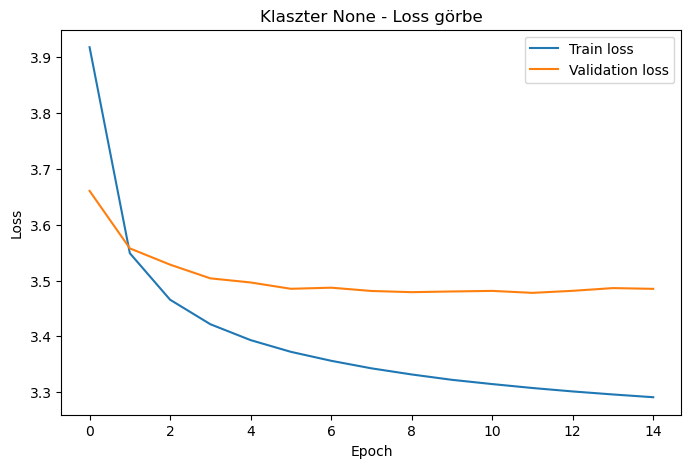

[Klaszter None] Test accuracy: 0.217, Test loss: 3.458
Eredmény elmentve: results_cluster3.csv


In [ ]:
# 3-as klaszter


CLUSTER_ID = 3

# Adatok betöltése + klaszterezés

df_proc_wclu = load_and_cluster("../lstm_egyeni/df_test_10k.csv")

# Kiválasztott klaszter
df_clu = df_proc_wclu[df_proc_wclu["cluster"] == CLUSTER_ID]

print(f"\n=== Klaszter {CLUSTER_ID} ===")
res = run_cluster_model_lstm_multi(df_clu, seq_len=20, epochs=20)

if res:
    res["cluster"] = CLUSTER_ID
    out_file = f"results_cluster{CLUSTER_ID}.csv"
    pd.DataFrame([res]).to_csv(out_file, index=False)
    print(f"Eredmény elmentve: {out_file}")